<a href="https://colab.research.google.com/github/jayakhan/document-classification/blob/main/lstm_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import numpy as np
import nltk
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Set Model Hyperparameters

In [38]:
#Hyperparameters
vocab_size = 2000
embedding_dim = 64
max_length = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

## Load Real Dataset

In [39]:
articles = []
labels = []
with open('/content/20ng-train-stemmed.txt') as file:
  docs = file.readlines()
  for line in docs:
    labels.append(line.split('\t')[0])
    article = line.split('\t')[1]
    for word in STOPWORDS:
      token = ' ' + word + ' '
      article = article.replace(token, ' ')
      article = article.replace(' ', ' ')
    articles.append(article)

In [40]:
labels_new = []
for i in labels:
  i = i.replace('.', '')
  i = i.replace('-', '')
  labels_new.append(i)

## Split data into training and validation

In [41]:
train_articles, validation_articles, train_labels, validation_labels = train_test_split(articles, labels_new, test_size=0.3, stratify=labels_new)

In [42]:
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

7905
7905
3388
3388


## Check distribution of training and validation datasets

In [43]:
pd.Series(train_labels).value_counts()

recsporthockey          420
socreligionchristian    419
recmotorcycles          419
recsportbaseball        418
recautos                416
scicrypt                416
scimed                  416
compwindowsx            415
scispace                415
scielectronics          414
compsysibmpchardware    413
miscforsale             409
compgraphics            409
compsysmachardware      405
composmswindowsmisc     400
talkpoliticsmideast     395
talkpoliticsguns        381
altatheism              336
talkpoliticsmisc        325
talkreligionmisc        264
dtype: int64

In [60]:
pd.Series(validation_labels).value_counts()

recsporthockey          180
recmotorcycles          179
scicrypt                179
socreligionchristian    179
recsportbaseball        179
scispace                178
recautos                178
scimed                  178
compwindowsx            178
compsysibmpchardware    177
scielectronics          177
miscforsale             176
compgraphics            175
compsysmachardware      173
composmswindowsmisc     172
talkpoliticsmideast     169
talkpoliticsguns        164
altatheism              144
talkpoliticsmisc        140
talkreligionmisc        113
dtype: int64

## Tokenization and Sequencing - Articles

In [45]:
# Tokenize articles for training datasets
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
train_sequences = tokenizer.texts_to_sequences(train_articles)
validation_sequences = tokenizer.texts_to_sequences(validation_articles)

print(train_sequences[10])
print(validation_sequences[10])

[265, 1854, 5, 1, 1, 1, 1, 1, 1, 4, 22, 36, 265, 1854, 232, 12, 1855, 1, 12, 1, 1, 1, 1, 1951, 785, 1, 1, 684, 1, 1186, 1, 1, 1884, 372, 49, 1, 1, 1, 1, 1, 1]
[1, 73, 1625, 788, 1, 1, 198, 1996, 1, 4, 170, 82, 1535, 788, 875, 16, 1, 93, 87, 900, 1, 1, 1, 83, 8, 398, 1535, 1, 537, 1, 1, 762, 57, 1, 1, 11, 292, 10, 1291, 1, 148, 12, 1, 1050, 16, 97, 237, 1, 12, 1971, 591, 1, 1218, 1256, 57, 203, 1, 788, 2, 10, 918, 1, 112, 1, 1, 1060, 1478, 1, 1, 2, 72, 178, 277, 229, 1]


In [46]:
# Padding to the end of the training and validation articles
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

print(len(validation_sequences[10]))
print(len(validation_padded[10]))

51
500
198
500
41
500
75
500


## Tokenization and Sequencing - Labels

In [47]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels_new)
training_label_seq = np.asarray(label_tokenizer.texts_to_sequences(train_labels)).astype('float32')
validation_label_seq = np.asarray(label_tokenizer.texts_to_sequences(validation_labels)).astype('float32')
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[20.]
[5.]
[20.]
(7905, 1)
[15.]
[15.]
[12.]
(3388, 1)


## Model Building

In [53]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 2000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          128000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
Total params: 204,384
Trainable params: 204,384
Non-trainable params: 0
_________________________________________________________________


In [49]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, None) <dtype: 'float32'>
(None, 32) <dtype: 'float32'>
embedding_2 (None, None) float32
dropout_6 (None, None, 64) float32
bidirectional_2 (None, None, 64) float32
dropout_7 (None, 128) float32
dense_4 (None, 128) float32
dropout_8 (None, 64) float32
dense_5 (None, 64) float32


[None, None, None, None, None, None, None]

## Check dataset before model fitting

In [50]:
print(train_padded.shape)
print(training_label_seq.shape)
print(validation_padded.shape)
print(validation_label_seq.shape)

(7905, 500)
(7905, 1)
(3388, 500)
(3388, 1)


In [51]:
print(type(train_padded))
print(type(training_label_seq))
print(type(validation_padded))
print(type(validation_label_seq))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [54]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
248/248 - 59s - loss: 2.7753 - accuracy: 0.1336 - val_loss: 2.0728 - val_accuracy: 0.3427 - 59s/epoch - 237ms/step
Epoch 2/10
248/248 - 54s - loss: 1.5759 - accuracy: 0.4673 - val_loss: 1.5149 - val_accuracy: 0.4867 - 54s/epoch - 218ms/step
Epoch 3/10
248/248 - 54s - loss: 1.0147 - accuracy: 0.6745 - val_loss: 1.1058 - val_accuracy: 0.6656 - 54s/epoch - 218ms/step
Epoch 4/10
248/248 - 54s - loss: 0.7187 - accuracy: 0.7819 - val_loss: 1.0410 - val_accuracy: 0.6989 - 54s/epoch - 218ms/step
Epoch 5/10
248/248 - 54s - loss: 0.5120 - accuracy: 0.8463 - val_loss: 0.9133 - val_accuracy: 0.7541 - 54s/epoch - 219ms/step
Epoch 6/10
248/248 - 54s - loss: 0.4021 - accuracy: 0.8769 - val_loss: 0.9340 - val_accuracy: 0.7497 - 54s/epoch - 219ms/step
Epoch 7/10
248/248 - 54s - loss: 0.3243 - accuracy: 0.9018 - val_loss: 0.9398 - val_accuracy: 0.7574 - 54s/epoch - 218ms/step
Epoch 8/10
248/248 - 54s - loss: 0.2750 - accuracy: 0.9185 - val_loss: 0.9645 - val_accuracy: 0.7615 - 54s/epoch - 218

## Model Evaluation

In [55]:
score = model.evaluate(validation_padded, validation_label_seq, verbose=10)

print("Loss:%.3f Accuracy: %.3f" % (score[0], score[1]))

Loss:1.003 Accuracy: 0.772


In [56]:
from sklearn.metrics import classification_report

y_pred = model.predict(validation_padded, batch_size=64, verbose=10)
y_pred_bool = np.argmax(y_pred, axis=1)

In [58]:
print(classification_report(validation_label_seq.copy(), y_pred_bool.copy()))

              precision    recall  f1-score   support

         1.0       0.89      0.86      0.87       180
         2.0       0.77      0.80      0.79       179
         3.0       0.84      0.80      0.82       179
         4.0       0.87      0.78      0.82       179
         5.0       0.93      0.88      0.90       179
         6.0       0.75      0.86      0.80       178
         7.0       0.81      0.73      0.77       178
         8.0       0.77      0.71      0.74       178
         9.0       0.87      0.86      0.86       178
        10.0       0.79      0.55      0.65       177
        11.0       0.67      0.68      0.68       177
        12.0       0.69      0.71      0.70       176
        13.0       0.64      0.74      0.69       175
        14.0       0.67      0.75      0.71       173
        15.0       0.67      0.77      0.72       172
        16.0       0.89      0.88      0.88       169
        17.0       0.84      0.87      0.86       164
        18.0       0.66    

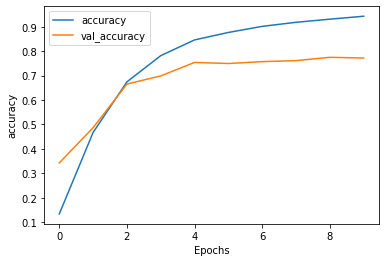

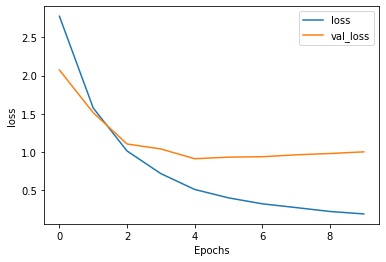

In [59]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")